# Week 6 Day 3: Fitting

## Objectives

* Learn how to interpolate using several methods
* Learn how to perform a simple fit on data
* Learn about various tools for data fitting

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Let's prepare a set of "semi-continuous" values to interpolate on.

In [9]:
x = np.linspace(0, 200, 100)

And, here's the data for a cross-section of resonant scattering of a neutron from a nucleus.

In [10]:
x_data = np.linspace(0, 200, 9)
y_data = np.array([10.6, 16.0, 45.0, 83.5, 52.8,
                   19.9, 10.8, 8.25, 4.7])
# e_data = np.array([9.34, 17.9, 41.5, 85.5, 51.5,
#                    21.5, 10.8, 6.29, 4.14])
e_data = np.array([5, 7, 10, 12,
                   10, 7, 5, 4, 4])

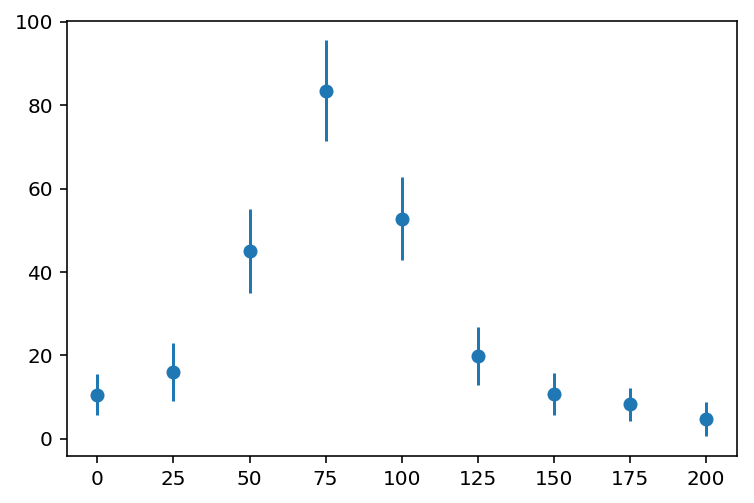

In [14]:
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt='o')
plt.show()

## Linear interpolation

We could numerically interpolate between values. The numpy function `interp` does this for us:

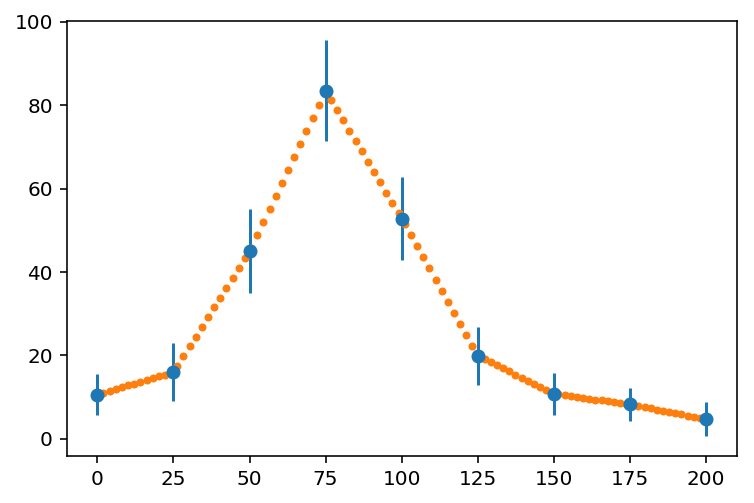

In [13]:
y = np.interp(x, x_data, y_data)
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt='o')
ax.plot(x, y, '.' )
plt.show()

## Lagrange interpolation

We can build our own Lagrange interpolation function:

$$
g(x)
=
\sum_{i=1}^{n}
g_i \lambda_i(x)
$$

$$
\lambda_i(x)
=
\prod_{j(\ne i)=1}^{n}
\frac{x - x_n}
     {x_i - x_n}
$$

In [20]:
def interp_langrange(x_data, y_data, x):
    'A custom Lagrange interpolate function.'
    
    # The shape will be N x N x n, where N is the number of points
    # in x and y, and n is the number of points in the result.
    x = np.asarray(x)
    x = x.reshape(1,1,-1)
    
    # Make grid. Have one "throw away" diminsion to make [N,N,1] shaped arrays
    x_n, x_i, _ = np.meshgrid(x_data, x_data, np.array([1]))
    
    # Using a mask here avoids numpy warnings and makes the product easy
    x_n = np.ma.array(x_n, mask=np.eye(x_data.shape[0]))
    x_i = np.ma.array(x_i, mask=np.eye(x_data.shape[0]))
    
    V = (x - x_n) / (x_i - x_n)
    v = np.prod(V, axis=1).data # Convert back to non-masked arrays
    
    return y_data @ v

# This was added to test interp_langrange
x_d2 = np.array([0,1,2,4])
y_d2 = np.array([-12, -12, -24, -60])

interp_langrange(x_d2, y_d2, [.5, 4]) # should be -10.125 and -60

array([-10.125, -60.   ])

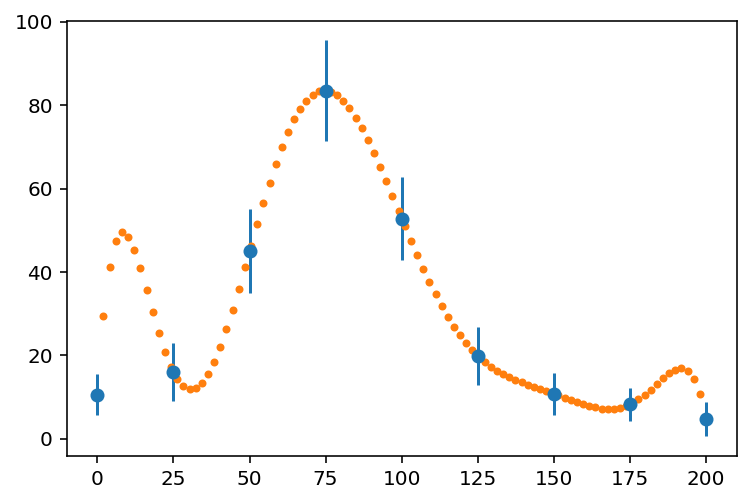

In [21]:
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt='o')
ax.plot(x, interp_langrange(x_data, y_data, x), '.')
plt.show()

Of course, you shouldn't be writing your own algorithms for something that is generally useful - it's included in SciPy. Let's see what that would have looked like instead:

In [23]:
from scipy import interpolate

In [26]:
p = interpolate.lagrange(x_data, y_data) # Makes a callable object "p"

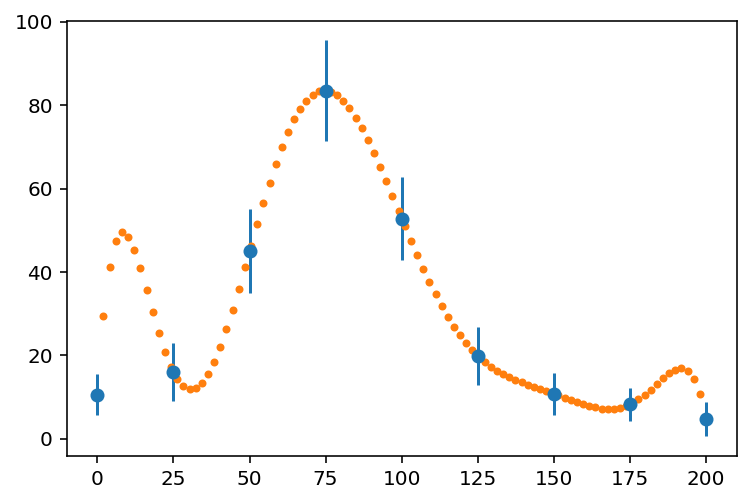

In [25]:
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt='o')
ax.plot(x, p(x), '.')
plt.show()

## Cubic splines

This is a visually appealing method for interpolation. It makes small cubic polynomial fits, with the further requirement that they smoothly connect to the next segment (thus looks better than the similar integration tool we saw earlier).

In [10]:
spline = interpolate.CubicSpline(x_data, y_data)

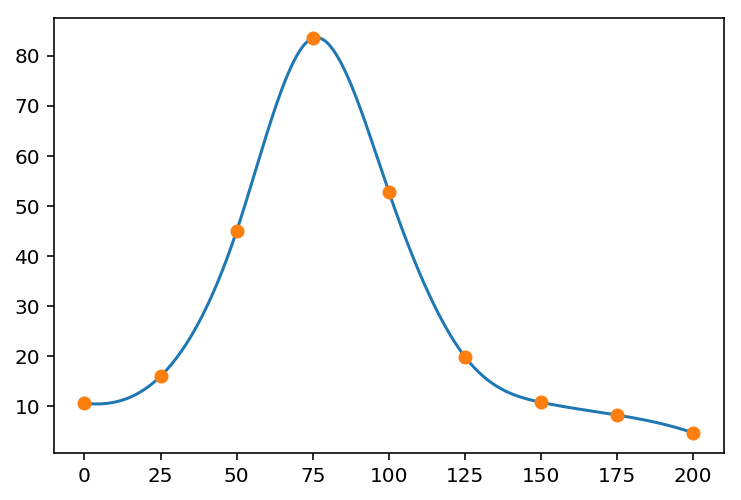

In [11]:
fig, ax = plt.subplots()
ax.plot(x, spline(x))
ax.plot(x_data, y_data, 'o')
plt.show()

## Curve fitting

We'll start with using the scipy optimize package. We'll look at how to do this ourselves with a simple function later.

In [28]:
from scipy.optimize import curve_fit

Our fit function is a theoretical model: a Breit-Wigner resonance:

$$
f(E) =
\frac{f_r}{\left(E-E_r\right)^2 + \Gamma^2/4}
$$

In [29]:
def f(E, f_r, E_r, Γ):
    return f_r / ((E - E_r)**2 + Γ**2/4)

Now, we look up the definition of curve_fit (using shift-tab, `curve_fit?`, or `help(curve_fit)`), and then feed it the parameters it wants:

In [32]:
popt, pcov = curve_fit(f, x_data, y_data,
                       p0=[1.,1.,1.],
                       sigma=e_data,
                       absolute_sigma=True)

It returns two objects; the array of fit value, and a covariance matrix.

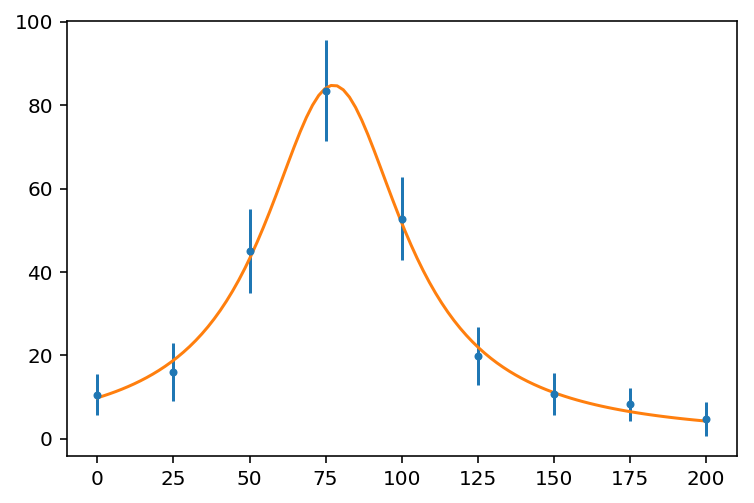

In [33]:
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt='.')
ax.plot(x, f(x, *popt))
plt.show()

## Advanced usage: The Uncertainties package

Let's use that correlation matrix that `curve_fit` returned! If you have the uncertainties package, you can make uncertain values - even ones related through an covariance matrix.

In [34]:
from uncertainties import correlated_values, unumpy

In [35]:
copt = correlated_values(popt, pcov)

Now, since we can compute the value + uncertainty for a calculation, including the correct relationship between variables, we can compute the function again, and plot a shaded uncertainty band.

In [36]:
def plot_with_unc(x, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    y_nv = unumpy.nominal_values(y)
    y_sd = unumpy.std_devs(y)
    
    line, = ax.plot(x, y_nv)
    ax.fill_between(x,
                    y_nv - y_sd,
                    y_nv + y_sd,
                    color=line.get_color(),
                    alpha=.2)

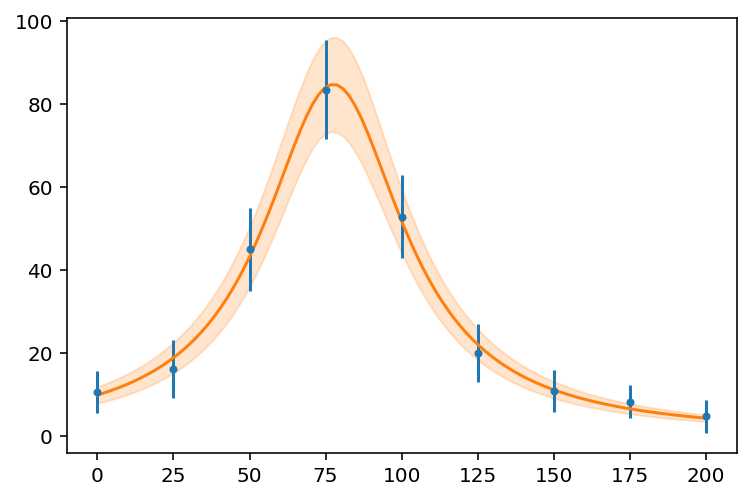

In [37]:
fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, e_data, fmt='.')
plot_with_unc(x, f(x, *copt), ax=ax)
plt.show()

## Linear least squares

Let's do a least squares fit ourselves. As long as we have a linear dependence *on the parameters*, we can solve this with linear algebra.

Some data:

In [38]:
t = np.linspace(1,2)
x = np.array([1., 1.1, 1.24, 1.35, 1.451, 1.5, 1.92])
y = np.array([0.52, 0.8, 0.7, 1.8, 2.9, 2.9, 3.6])
sig = np.array([.1, .1, .2, .3, .2, .1, .1])

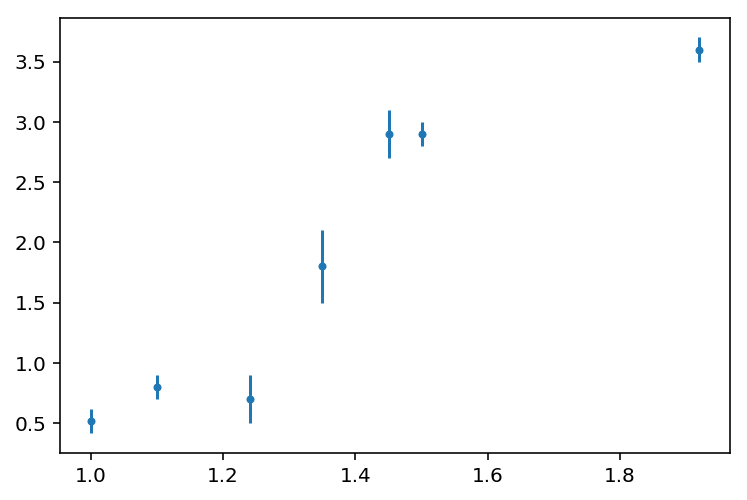

In [21]:
fig, ax = plt.subplots()
ax.errorbar(x, y, sig, fmt='.')
plt.show()

## Manual least squares fitting:

Fitting function:

$$
g(x_i) = a_0 x_i^2 + a_1 x_i + a_2
\tag{1}
$$

If you compute the minimum of $\chi^2$, you get:

$$
\sum _i
\frac{g(x_i)}{\sigma_i^2}
\frac{\partial g ( x_i)}{\partial a_m}
=
\sum _i
\frac{y_i}{\sigma_i^2}
\frac{\partial g ( x_i)}{\partial a_m}
\tag{2}
$$

We can rewrite this as a matrix expression, expanding (2) in terms of (1):

$$
A x = b
\tag{3}
$$

$$
A = \left[
\begin{matrix}
 \sum_i \frac{x_i^4}{\sigma_i^2} & \sum_i \frac{x_i^3}{\sigma_i^2} & \sum_i \frac{x_i^2}{\sigma_i^2} \\
 \sum_i \frac{x_i^3}{\sigma_i^2} & \sum_i \frac{x_i^2}{\sigma_i^2} & \sum_i \frac{x_i^1}{\sigma_i^2} \\
 \sum_i \frac{x_i^2}{\sigma_i^2} & \sum_i \frac{x_i  }{\sigma_i^2} & \sum_i \frac{1    }{\sigma_i^2} \\
\end{matrix}
\right]
\tag{3.1}
$$

$$
b = \left[
\begin{matrix}
 \sum_i \frac{y_i x_i^2}{\sigma_i^2} \\
 \sum_i \frac{y_i x_i  }{\sigma_i^2} \\
 \sum_i \frac{y_i      }{\sigma_i^2} \\
\end{matrix}
\right]
\tag{3.2}
$$

$$
x = \left[
\begin{matrix}
 a_2 \\
 a_1 \\
 a_0 \\
\end{matrix}
\right]
\tag{3.3}
$$

In [22]:
sig2 = sig**2
ss = np.array([
    np.sum(x**4/sig2), np.sum(x**3/sig2), np.sum(x**2/sig2), np.sum(x/sig2), np.sum(1/sig2)
])
A = np.stack([ss[:3], ss[1:4], ss[2:]])

b = np.array([np.sum(x**2*y/sig2), np.sum(x*y/sig2), np.sum(y/sig2)])
print(b)

[2344.4035725 1420.0975     892.       ]


We could have been much more clever. Looking at the above expression for M, we could instead have created the powers, then raise to a matrix of powers! 

In [23]:
power = sum(np.mgrid[2:-1:-1,2:-1:-1])
Ap = np.sum(x[:,None,None]**power / sig[:,None,None]**2, axis=0)
assert np.all(A == Ap)

Exercise for the reader: try the same trick on `b`.

In [24]:
xvec = np.linalg.solve(A, b)
print(xvec)

[-2.76280268 11.66987644 -8.5698482 ]


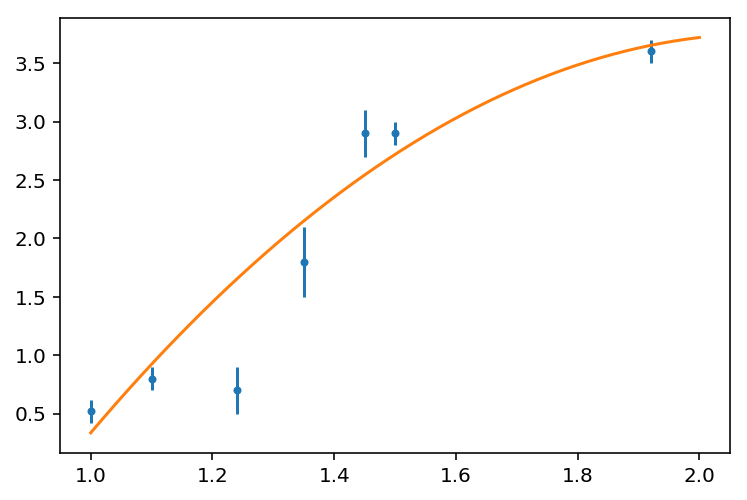

In [25]:
p = np.poly1d(xvec)
fig, ax = plt.subplots()
ax.errorbar(x, y, sig, fmt='.')
ax.plot(t, p(t))
plt.show()

#### Numpy Polyfit

I'm still not advocating that real fits be done this way. We could have just done this with the polyfit function in numpy:

In [26]:
xvec = np.polyfit(x, y, 2, w=1/sig)
p = np.poly1d(xvec)

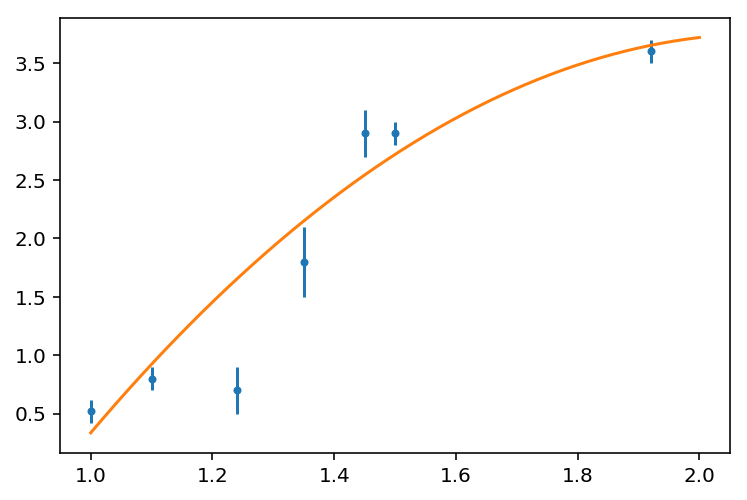

In [27]:
fig, ax = plt.subplots()
ax.errorbar(x, y, sig, fmt='.')
ax.plot(t, p(t))
plt.show()

#### Scipy curve fit

Or the more general scipy `curve_fit`:

In [42]:
def new_p(x, *values):
    return np.poly1d(values)(x)

xvec, _ = curve_fit(new_p, x, y, p0=[1,1,1],sigma=sig)
p = np.poly1d(xvec)

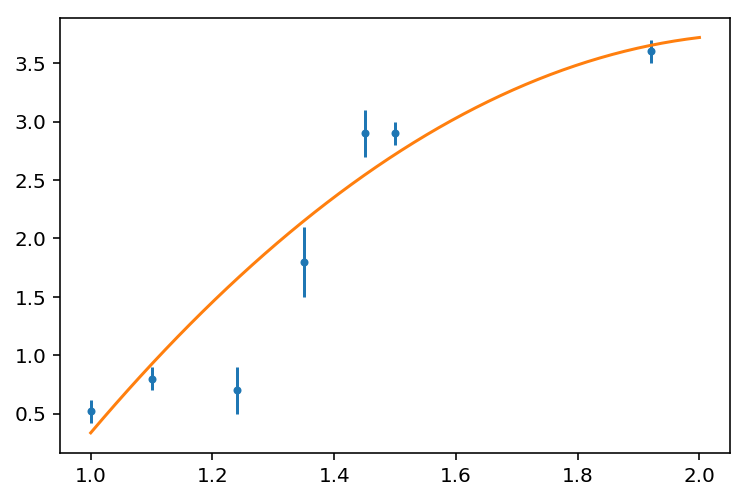

In [43]:
fig, ax = plt.subplots()
ax.errorbar(x, y, sig, fmt='.')
ax.plot(t, p(t))
plt.show()

### A 2D fit

Let's try in 2D. Try to fit the following data with a function of the form:

$$
f(x,y) = 
a \sin(b x) + c \cos(d y)
$$

In [53]:
state = np.random.RandomState(42)
x, y = np.ogrid[-np.pi:np.pi:100j,-np.pi:np.pi:100j]
z = 1.2*np.sin(2.3*x) + .6*np.cos(3.1*y) + state.rand(100,100)*.3

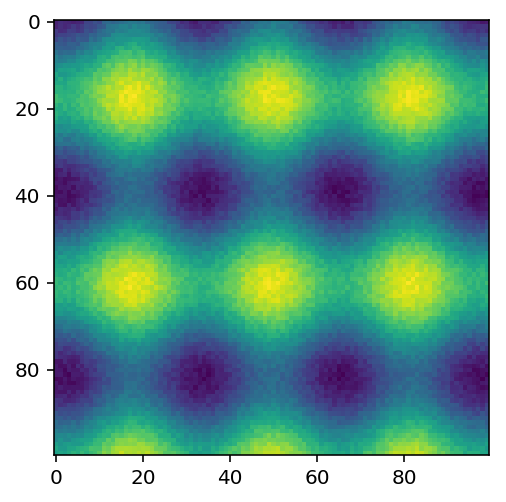

In [54]:
fig, ax = plt.subplots()
ax.imshow(z)
plt.show()

To get this into `curve_fit`, we have to jump through some hoops. We need to give x and y together (it will be used by the function exactly as we give it), and we need to return a 1D array of values to compare:

<font color="grey">
> Note: some older examples will show you a really odd syntax:
> 
> ```python
> def f((x,y), a, b, c, d):
> ```
>
> This was more trouble than it was worth and was dropped in Python 3. Just unpack yourself if you want to unpack. 

In [55]:
def f(xy, a, b, c, d):
    x,y = xy
    z = a*np.sin(b*x) + c*np.cos(d*y)
    return z.ravel()

We had to return a flattened array, since `curve_fit` only likes flat (1D) arrays. At this point, when computing a least squared fit, the result shape does not matter, so it's okay to do. (The fact we had to build it into our fitting function is really irritating, though). We'll need to do the same thing with `z`, as well, since it's going to be compared with the return value:

> Note: `flatten()`, `ravel()`, and `reshape(-1)` all do basically the same thing, but `flatten` always makes a copy, so `ravel` is usually better.

In [60]:
popt, pcov = curve_fit(f, [x,y], z.ravel(), [1,2,.5,3])

Let's use the uncertainties package again, this time to provide nicer printouts of the fit values: 

In [75]:
copt = correlated_values(popt, pcov)
for i in range(4):
    print('abcd'[i], '=', format(copt[i], 'P'))

a = 1.2019±0.0025
b = 2.3001±0.0010
c = 0.5952±0.0023
d = 3.0497±0.0023


Just for comparison, this is what it would have looked like if we calculated that ourselves:

In [76]:
for i in range(4):
    print('abcd'[i], '=', popt[i], "±", np.sqrt(pcov[i,i]))

a = 1.201865056760183 ± 0.0024522716182812446
b = 2.3000753649141643 ± 0.0009971958252061681
c = 0.5952341679572783 ± 0.0023497127186217666
d = 3.0496873705111316 ± 0.002285908398143492


Now, the result:

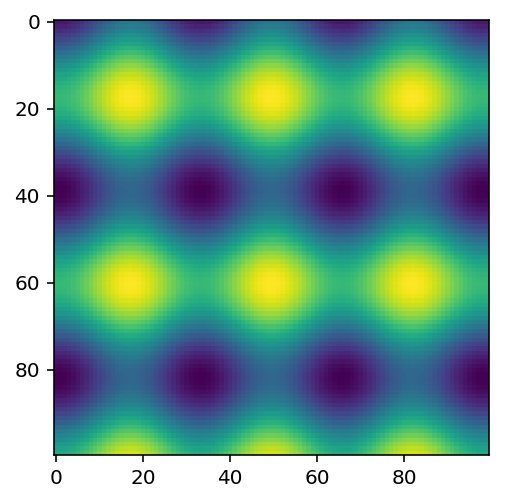

In [77]:
fig, ax = plt.subplots()
ax.imshow(f([x,y], *popt).reshape(100,100))
plt.show()

#### Try it yourself:

* What happens if your initial guess is not as good? Why?